## Dynamic Cutting Force Calculation in Face Milling by solving a 6 DOF Equations using Newmarks Method

#### References:
    1. A CUTTING FORCE MODEL FOR FACE MILLING OPERATIONS H. S. KIM and K. F. EHMANN: (Received 2 January 1991; in final form 20 August 1992)
    2. SS.Rao Mechanical Vibrations

### Model and Equations

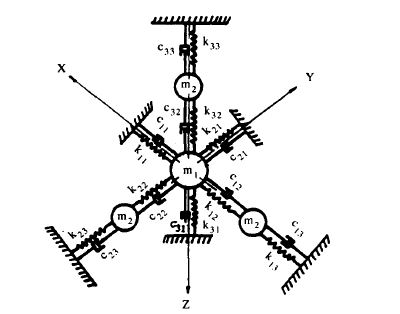

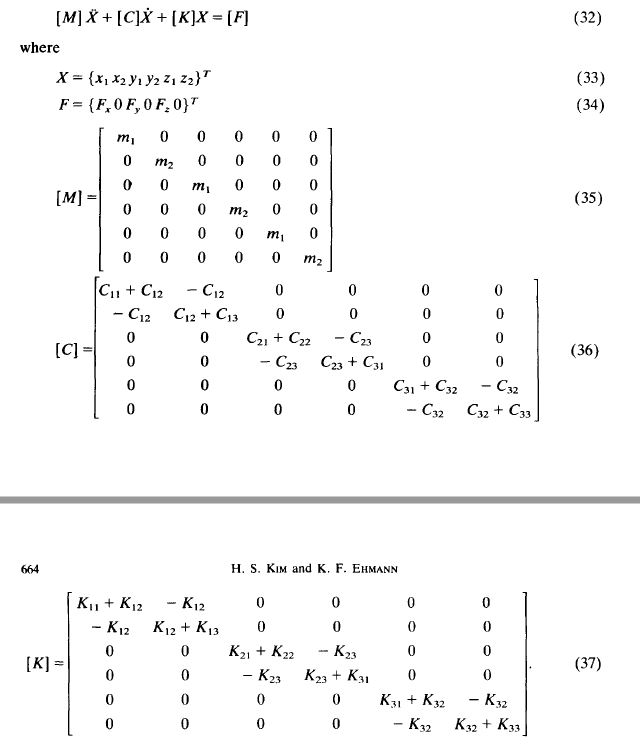

### Import Libraries

In [2]:
import numpy as np # Numpy
import scipy.signal as signal # Signal
import matplotlib.pyplot as plt # Plotting

### System Parameters

In [3]:
feed = 0.15 # Feed
app_ang = (45 * np.pi)/180 # approach Angle
doc = 1.5 # Depth of Cut
woc = 100 # Width of Cut
y=woc/2 # Half of Width of Cut
dia = 100 # Diameter of Tool
kc = 1800  # Specific Cutting Pressure of Material
z = 6 # Number of teeths in tool
cut_speed = 1000 # Cutting Speed in 
gamma_r = (14 * np.pi)/180  # Rake angle
gamma_a = (8 * np.pi)/180  # Axial Rake Angle
ka = 0.375 # Axial Force Constant
kr = 0.67 # Radial Force Constant

### Speed in RPM

In [4]:
speed = (1000 * cut_speed)/(np.pi * dia)

In [5]:
print('Speed in RPM:',speed)

Speed in RPM: 3183.0988618379065


### Get Minimum and Maximum Contact angles that the tool is in contact with the workpiece 

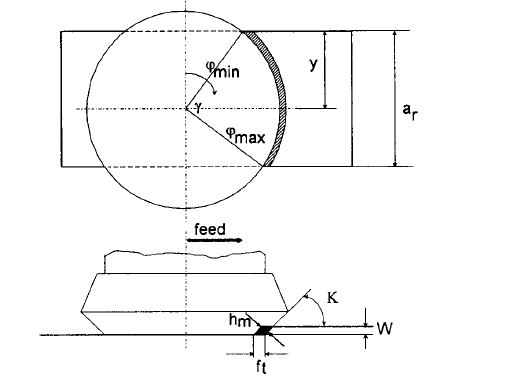

In [63]:
def angles():
    psi_min = (np.pi/2) - np.arcsin((2*y)/dia) # Minimum Angle.
    psi_max = (np.pi/2) + np.arcsin(2*(woc-y)/dia) # Maximum Angle

    gamma = psi_max - psi_min # Difference
    k=int((gamma*z)/(2*np.pi)  +1) # Number of Teeth in Contact
    return k, psi_min, psi_max, gamma

In [64]:
k, psi_min, psi_max, gamma = angles()

4


### Feed Speed

In [65]:
vf = k * speed * feed *(1e-3/60)
vf

0.03183098861837906

### Teeth angles of specific numbeer of teeth in contact at an instant.

In [66]:
def teeth_angles():
    li=[]
    for i in range(k):
        psi = psi_min + ((2*np.pi/z)*(i+1-1))
        li.append(psi)
    return li

In [67]:
li_ang = teeth_angles()
li_ang

[0.0, 1.0471975511965976, 2.0943951023931953, 3.141592653589793]

### Static Forces in Tangential, Radial and Axial Forces

In [68]:
def abc_forces():
    li_force=[]
    li_rad=[]
    li_axi =[]
    for i in range(k):
        a = feed * np.sin(li_ang[i]) * doc
        force = (kc * a) /(np.cos(gamma_r) * np.cos(gamma_a)) 
        force_rad = kr * force
        force_axi = ka * force
        li_rad.append(force_rad)
        li_axi.append(force_axi)
        li_force.append(force)
        
    return li_force, li_rad, li_axi

In [69]:
li_abc_ft, li_abc_fr, li_abc_fa = abc_forces()
print('Tangential Force: ', np.round(sum(li_abc_ft),2))
print('Radial Force: ', np.round(sum(li_abc_fr),2))
print('Axial Force: ', np.round(sum(li_abc_fa),2))

Tangential Force:  730.06
Radial Force:  489.14
Axial Force:  273.77


### Torque

In [70]:
torque = np.round(sum(li_abc_ft),2) * (dia/2) * 1e-3
torque

36.503

### Static Forces in Inertial Reference

In [14]:
def xyz_forces():
    li_force_xyz = []
    li_rad_xyz =[]
    li_axi_xyz = []
    for i in range(k):
        ft =  li_abc_ft[i]*np.cos(gamma_r)*np.cos(gamma_a) + li_abc_fr[i]*np.cos(app_ang)*np.sin(gamma_r) + li_abc_fa[i]*np.cos(app_ang)*np.sin(gamma_a)
        fa = -li_abc_ft[i]*np.sin(gamma_a) + li_abc_fr[i]*np.sin(app_ang) +li_abc_fa[i]*np.cos(app_ang)*np.cos(gamma_a)
        fr = -li_abc_ft[i]*np.sin(gamma_r)*np.cos(gamma_a) +li_abc_fr[i]*np.cos(app_ang)*np.cos(gamma_r) - li_abc_fa[i]*np.sin(app_ang)*np.cos(gamma_r)
        li_force_xyz.append(ft)
        li_rad_xyz.append(fa)
        li_axi_xyz.append(fr)
    return li_force_xyz, li_rad_xyz, li_axi_xyz


In [15]:
li_force_xyz, li_rad_xyz, li_axi_xyz = xyz_forces()
print('XYZ-Cordiante X Force: ', np.round(sum(li_force_xyz),2))
print('XYZ-Cordiante Y Force: ', np.round(sum(li_rad_xyz),2))
print('XYZ-Cordiante Z Force: ', np.round(sum(li_axi_xyz),2))

XYZ-Cordiante X Force:  541.4
XYZ-Cordiante Y Force:  290.65
XYZ-Cordiante Z Force:  -18.09


### Static Instantenous Forces

In [16]:
def inst_forces():
    li_x_inst = []
    li_y_inst =[]
    li_z_inst = []
    for i in range(k):
        fx = (li_force_xyz[i] * np.sin(li_ang[i])) - (li_rad_xyz[i] * np.cos(li_ang[i]))
        fy = (li_force_xyz[i] * np.cos(li_ang[i])) + (li_rad_xyz[i] * np.sin(li_ang[i]))
        fz = li_axi_xyz[i]
        li_x_inst.append(fx)
        li_y_inst.append(fy)
        li_z_inst.append(fz)
    return li_x_inst, li_y_inst, li_z_inst

In [17]:
li_x_inst, li_y_inst, li_z_inst = inst_forces()
print('Instantaneous X Force: ', np.round(sum(li_x_inst),2))
print('Instantaneous Y Force: ', np.round(sum(li_y_inst),2))
print('Instantaneous Z Force: ', np.round(sum(li_z_inst),2))

Instantaneous X Force:  468.86
Instantaneous Y Force:  251.71
Instantaneous Z Force:  -18.09


### Mass, Spring Constant and Damping

In [18]:
m1 = 3 # Mass of Tool
m2 = 2 # Mass of Workpiece

k11 = 1.4 * np.power(10,7) # Spring Constant
k12 = 1.2 * np.power(10,7) # Spring Constant
k13 = 1.4 * np.power(10,7) # Spring Constant
k21 = 1.8 * np.power(10,7) # Spring Constant
k22 = 1.2 * np.power(10,7) # Spring Constant
k23 = 1.8 * np.power(10,7) # Spring Constant
k31 = 1.4 * np.power(10,7) # Spring Constant
k32 = 1.2 * np.power(10,7) # Spring Constant
k33 = 1.8 * np.power(10,7)# Spring Constant

c11 = 400*0.00 # Damping Constant
c12 = 200*0.00 # Damping Constant
c13 = 400*0.00 # Damping Constant
c21 = 400*0.00 # Damping Constant
c22 = 200*0.00 # Damping Constant
c23 = 400*0.00 # Damping Constant
c31 = 400*0.00 # Damping Constant
c32 = 200*0.00 # Damping Constant
c33 = 400*0.00 # Damping Constant

### Mass Matrix

In [19]:
M = [[m1,0,0,0,0,0],
     [0,m2,0,0,0,0],
     [0,0,m1,0,0,0],
     [0,0,0,m2,0,0],
     [0,0,0,0,m1,0],
     [0,0,0,0,0,m2]]
M = np.asarray(M)
M_inv = np.linalg.inv(M)

### Damping Matrix

In [17]:
C = [[c11+c12, -c12, 0, 0, 0, 0],
     [-c12,c12+c13,0,0,0,0],
     [0,0,c21+c22,-c22,0,0],
     [0,0,-c22,c23+c22,0,0],
     [0,0,0,0,c31+c32,-c32],
     [0,0,0,0,-c32,c32+c33]]
C = np.asarray(C)

### Spring Constant Matrix

In [18]:
K = [[k11+k12, -k12, 0, 0, 0, 0],
     [-k12,k12+k13,0,0,0,0],
     [0,0,k21+k22,-k22,0,0],
     [0,0,-k22,k23+k22,0,0],
     [0,0,0,0,k31+k32,-k32],
     [0,0,0,0,-k32,k32+k33]]
K = np.asarray(K)

### Exitation Forces

In [19]:
fx = sum(li_x_inst)
fy = sum(li_y_inst)
fz = sum(li_z_inst)

### Constants in Newmark Method

In [20]:
alpha1 = 1
alpha2 = -np.tan(gamma_r)
alpha3 = -np.tan(gamma_a)/np.cos(gamma_r)
beta1 = (np.cos(app_ang) * np.tan(gamma_r))/np.cos(gamma_a)
beta2 = np.cos(app_ang)/np.cos(gamma_a)
beta3 = np.sin(app_ang)/(np.cos(gamma_a) * np.cos(gamma_r))
gamma1 = (np.tan(gamma_a)*np.cos(app_ang))/np.cos(gamma_r)
gamma2 = -np.sin(app_ang)/np.cos(gamma_a)
gamma3 = np.cos(app_ang)/np.cos(gamma_r)

### Initial Conditions of Position and Velocity

In [21]:
dx1, dx2 = 0.005, 0.000
dy1, dy2 = 0.000, 0.00
dz1, dz2 = 0.001, 0.00
vx1, vx2 = 0, 0
vy1, vy2 = 0, 0
vz1, vz2 = 0, 0

### Acceleration

In [22]:
x = [[dx1],[dx2],[dy1],[dy2],[dz1],[dz2]]     # Displacement
xx = [[vx1],[vx2],[vy1],[vy2],[vz1],[vz2]]    # Velocity
fnew = [[fx], [0], [fy], [0], [fz], [0]]      # Force vector
x = np.asarray(x)     # To numpy array
xx = np.asarray(xx)   # To numpy array
fnew = np.asarray(fnew)     # To numpy array
print(x.shape, xx.shape, fnew.shape)
e = fnew - np.matmul(C, xx) - np.matmul(K, x)  # Expression in Eqn 11.26
xxx = np.matmul(M_inv, e)   # Acceleration
xxx

(6, 1) (6, 1) (6, 1)


array([[-43041.96188976],
       [ 30000.        ],
       [   134.22995225],
       [     0.        ],
       [ -8589.908832  ],
       [  6000.        ]])

In [23]:
xj = np.copy(x)
xxj = np.copy(xx)
xxxj = np.copy(xxx)

### Process to find the Dynamic Forces

In [24]:
dt = 0.0001            # Time step
alpha = 0.25
beta = 0.5
t = np.arange(0,0.01,dt) # Time Sample
n = t.shape[0]

a = 1/(alpha * dt**2)  # Coefficient 1
b =beta/(alpha * dt)        # Coefficient 2 
c = beta/alpha         # Coefficient 3
d = (1/(2.0*alpha))        # Coefficient 4

exp = a*M + b*C + K 
keff = np.linalg.inv(exp)

speed_constant = (2*np.pi*speed)/(60*z)
li_DFx =[]  # List to store DFx
li_DFy =[]  # List to store DFy
li_DFz =[]  # List to Store DFz

li_x1 = []
li_x2 = []
li_y1 = []
li_y2 = []
li_z1 = []
li_z2 = []

for i in range(n):
    
    li_dfx = [] # List to append dfx
    li_dfy = [] # List to append dfy
    li_dfz = [] # List to append dfz
    
    for j in range(k):  # Iterate over every Teeth
        
        if i<1:
            fnew = [[fx], [0], [fy], [0], [fz], [0]]
            
        else:
            fnew = [[li_DFx[i-1]], [0], [li_DFy[i-1]], [0], [li_DFz[i-1]], [0]]
        fnew = np.asarray(fnew)
        
        e1 = (b*x) + (c-1)*xx + (c-2)*(dt/2)*xxx
        e2 = (a*x) + ((1/(alpha * dt))*xx) + (d-1)*xxx
        e3 = np.matmul(C, e1)
        e4 = np.matmul(M, e2)
        e5 = fnew + e3 + e4
        
        x_i = np.matmul(keff, e5)
        
        xxx_i = (a*(x_i - x)) - (1/(alpha*dt))*xx - (d-1)*xxx
        xx_i  = xx + (1-beta)*(dt*xxx) + beta*(dt*xxx_i)
        
        
        xi = x_i[0][0] - x_i[1][0]
        yi = x_i[2][0] - x_i[3][0]
        zi = x_i[4][0] - x_i[5][0]
        
        xo = xi*(j+1)*(gamma - (2*np.pi*speed)/(60*z))
        yo = yi*(j+1)*(gamma - (2*np.pi*speed)/(60*z))
        zo = zi*(j+1)*(gamma - (2*np.pi*speed)/(60*z))
        
        ux = xo - xi
        uy = yo - yi
        uz = zo - zi
        ui = np.sqrt(ux**2 + uy**2 + uz**2) 
        
        rixx = (alpha1 * np.sin(li_ang[j])) - (alpha2 * np.cos(li_ang[j]))
        rixy = (kr*( beta1*np.sin(li_ang[j]) - beta2*np.cos(li_ang[j]) ))
        rixz = (ka*( gamma1*np.sin(li_ang[j]) - gamma2*np.cos(li_ang[j]) ))
        
        riyx = (alpha1 * np.cos(li_ang[j])) + (alpha2 * np.sin(li_ang[j]))
        riyy = (kr*( beta1*np.cos(li_ang[j]) + beta2*np.sin(li_ang[j]) ))
        riyz = (ka*( gamma1*np.cos(li_ang[j]) + gamma2*np.sin(li_ang[j]) ))
        
        rizx = alpha3
        rizy = kr*beta3
        rizz = ka*gamma3
        
        dfx = kc * (rixx  + rixy + rixz) * ui 
        dfy = kc * (riyx  + riyy + riyz) * ui 
        dfz = kc * (rizx  + rizy + rizz) * ui  
        
        # Append to list
        li_dfx.append(dfx)
        li_dfy.append(dfy)
        li_dfz.append(dfz)
    
    x = x_i  
    xx = xx_i 
    xxx = xxx_i 
    
    li_x1.append(x[0][0])
    li_x2.append(x[1][0])
    li_y1.append(x[2][0])
    li_y2.append(x[3][0])
    li_z1.append(x[4][0])
    li_z2.append(x[5][0])
    
    # Equation 31  
    DFx = sum(li_x_inst) + sum(li_dfx)
    DFy = sum(li_y_inst) + sum(li_dfy)
    DFz = sum(li_z_inst) + sum(li_dfz)

    # Append Forces to list
    li_DFx.append(DFx)
    li_DFy.append(DFy)
    li_DFz.append(DFz)

    # Convert to Numpy array
DFx = np.asarray(li_DFx)
DFy = np.asarray(li_DFy)
DFz = np.asarray(li_DFz)
        

### Dynamic Forces in X Direction.

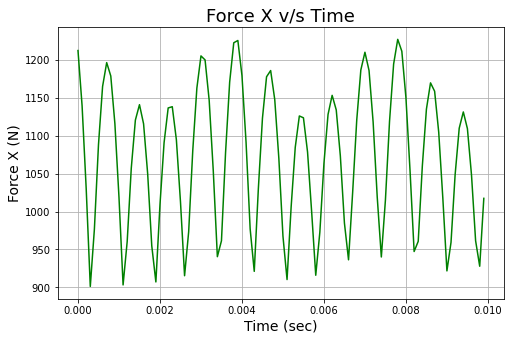

In [34]:
plt.figure(figsize=(8,5))
plt.plot(t, DFx, 'green')
plt.xlabel('Time (sec)',  fontdict={'fontsize':14})
plt.ylabel('Force X (N)',  fontdict={'fontsize':14})
plt.title('Force X v/s Time', fontdict={'fontsize':18})
plt.grid(True)
plt.show()

### Dynamic Forces in Y-Direction

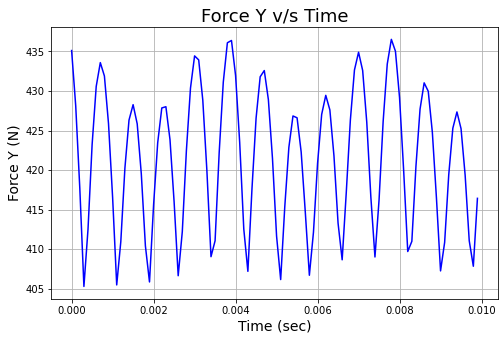

In [35]:
plt.figure(figsize=(8,5))
plt.plot(t, DFy, 'blue')
plt.xlabel('Time (sec)',  fontdict={'fontsize':14})
plt.ylabel('Force Y (N)',  fontdict={'fontsize':14})
plt.title('Force Y v/s Time', fontdict={'fontsize':18})
plt.grid(True)
plt.show()

### Dynamic Forces in Z-Direction

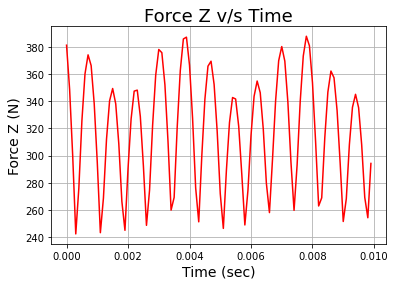

In [37]:
plt.figure(figsize=(6,4))
plt.plot(t, DFz, 'red')
plt.xlabel('Time (sec)',  fontdict={'fontsize':14})
plt.ylabel('Force Z (N)',  fontdict={'fontsize':14})
plt.title('Force Z v/s Time', fontdict={'fontsize':18})
plt.grid(True)
plt.show()

In [28]:
x1 = np.array(li_x1)
x2 = np.array(li_x2)
y1 = np.array(li_y1)
y2 = np.array(li_y2)
z1 = np.array(li_z1)
z2 = np.array(li_z2)

### Displacement of Tool and Workpiece in X-Direction

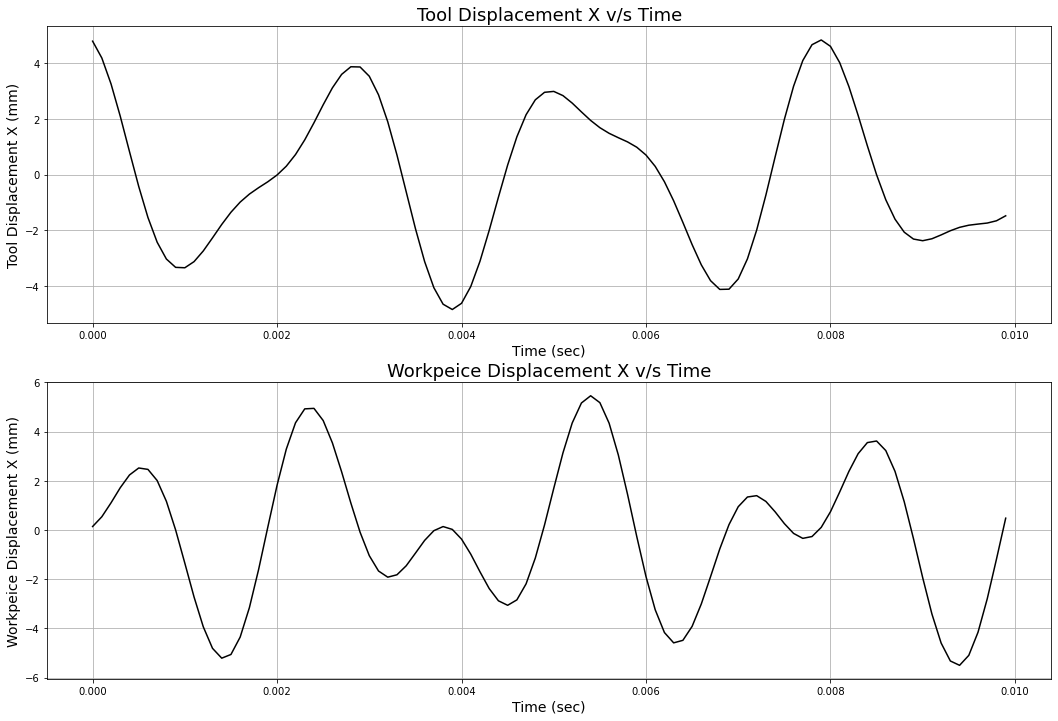

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,12))
axes[0].plot(t, x1*1000, 'black')
axes[1].plot(t, x2*1000, 'black')
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_title('Tool Displacement X v/s Time',  fontdict={'fontsize':18})
axes[1].set_title('Workpeice Displacement X v/s Time',  fontdict={'fontsize':18})
axes[0].set_xlabel('Time (sec)', fontdict={'fontsize':14})
axes[1].set_xlabel('Time (sec)', fontdict={'fontsize':14})
axes[0].set_ylabel('Tool Displacement X (mm)', fontdict={'fontsize':14})
axes[1].set_ylabel('Workpeice Displacement X (mm)', fontdict={'fontsize':14})
plt.show()

### Displacement of Tool and Workpiece in Y-Direction

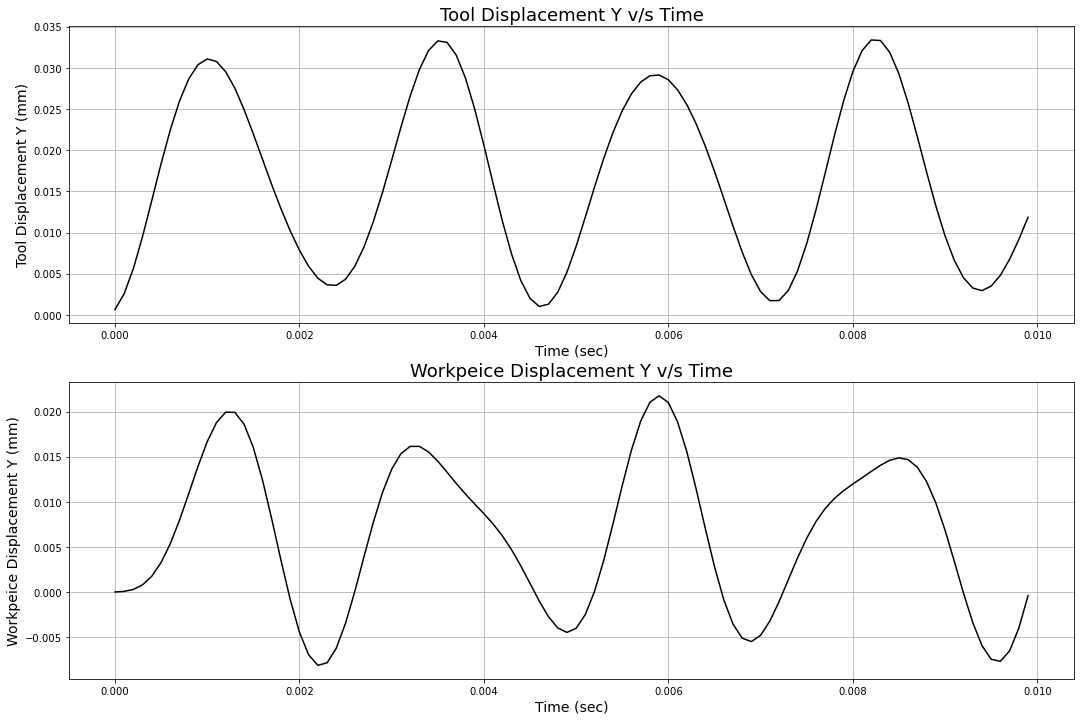

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,12))
axes[0].plot(t, y1*1000, 'black')
axes[1].plot(t, y2*1000, 'black')
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_title('Tool Displacement Y v/s Time',  fontdict={'fontsize':18})
axes[1].set_title('Workpeice Displacement Y v/s Time',  fontdict={'fontsize':18})
axes[0].set_xlabel('Time (sec)', fontdict={'fontsize':14})
axes[1].set_xlabel('Time (sec)', fontdict={'fontsize':14})
axes[0].set_ylabel('Tool Displacement Y (mm)', fontdict={'fontsize':14})
axes[1].set_ylabel('Workpeice Displacement Y (mm)', fontdict={'fontsize':14})
plt.show()

### Displacement of Tool and Workpiece in Z-Direction

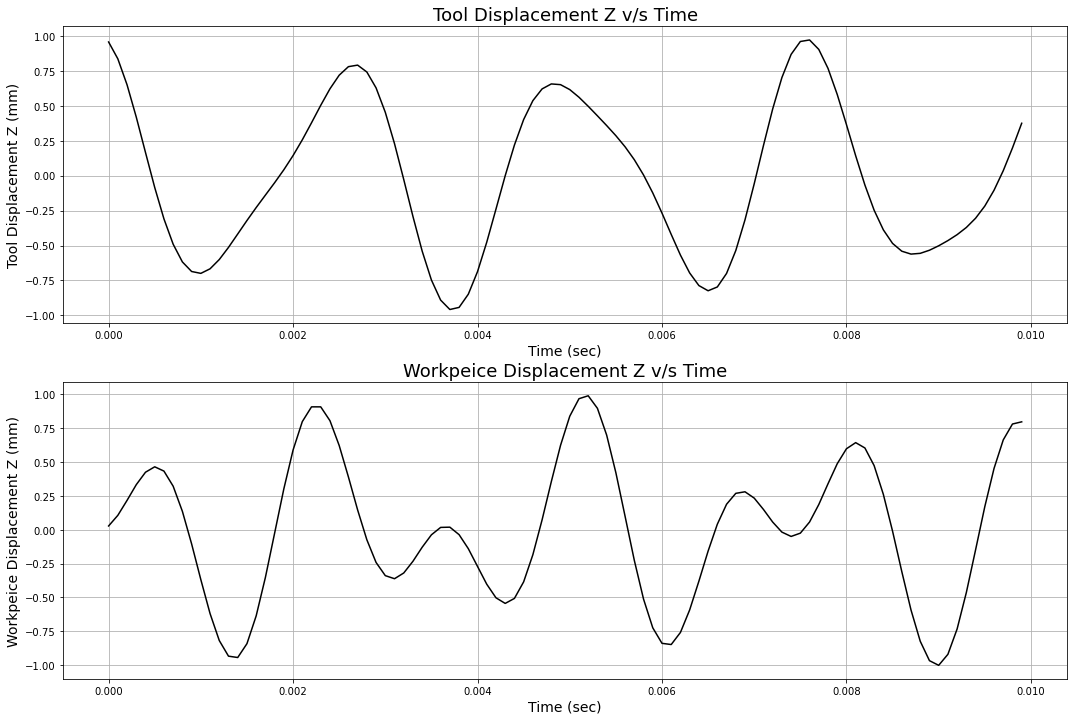

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,12))
axes[0].plot(t, z1*1000, 'black')
axes[1].plot(t, z2*1000, 'black')
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_title('Tool Displacement Z v/s Time',  fontdict={'fontsize':18})
axes[1].set_title('Workpeice Displacement Z v/s Time',  fontdict={'fontsize':18})
axes[0].set_xlabel('Time (sec)', fontdict={'fontsize':14})
axes[1].set_xlabel('Time (sec)', fontdict={'fontsize':14})
axes[0].set_ylabel('Tool Displacement Z (mm)', fontdict={'fontsize':14})
axes[1].set_ylabel('Workpeice Displacement Z (mm)', fontdict={'fontsize':14})
plt.show()